<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.03.Colab_Median_Mosaic_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

<a id="top"></a>
# Landsat-8 Cloud-Filtered Median Mosaic

This notebook uses global Landsat-8 data from Google Earth Engine which has been indexed to work with the Open Data Cube. The selected data is used to create a custom Landsat-8 cloud-filtered median mosaic for any time period and location. The mosaic can be output as a GeoTIFF product for analysis in external GIS tools. The median mosaic is quite common and reflects the "median" value of cloud-free pixels for all spectral bands in the time series. 

Users should review the "Cloud Statistics" notebook for more information about the temporal and spatial samples that are used for any median mosaic. An understanding of the underlying data is important for creating a valid mosaic for further analyses. In many cases, cloud contamination will create poor or time-biased mosaics unless there are sufficient cloud-free pixels in the time series. With a careful review of the cloud coverage over a given region and time period, it is possible to improve the mosaics and avoid false outputs. 

Most mosaics are created for annual or seasonal time periods. In cloudy regions there may not be any clear (non-cloudy) pixels for the defined time window. If this is the case, those pixels will be masked from the final median mosaic product and be shown as "white" regions in the output image. 

This baseline notebook runs in about 5 minutes. The default region (0.15 degrees square) and time window (one year) uses about 20% of the allocated RAM memory. Selecting larger regions and time windows should be done carefully to avoid exceeding the system limits or having long run times. For example, regions near 0.5-degree square will "crash" the code and not run to completion.

In [ ]:
# Suppress Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Median Mosaic')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Utilities
import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [6]:
# MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Mombasa, Kenya
lat_long = (-4.03, 39.62)
box_size_deg = 0.15

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Select a time range
# The inputs require a format (Min,Max) using this date format (YYYY-MM-DD)
# The Landsat-8 allowable time range is: 2013-04-07 to current
time_extents = ('2020-01-01', '2020-12-31')

In [7]:
# The code below renders a map that can be used to view the region.
# It is possible to find new regions using the map below. 
# Use your mouse to zoom in/out to explore new regions
# Click on the map to view Lat-Lon coordinates of any location that could define the region boundary

from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## <span id="load_data">Load the Data and Mask the Clouds [&#9652;](#top)</span>

In [8]:
landsat_dataset = dc.load(latitude=latitude,longitude=longitude,platform=platform,time=time_extents,
                          product=product,measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [9]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

## <span id="mosaics">Create Median Mosaic and View the Results [&#9652;](#top)</span>

In [10]:
# Load the median mosaic function and create the median mosaic
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

In [11]:
# Load the plotting utility
from utils.data_cube_utilities.dc_rgb import rgb

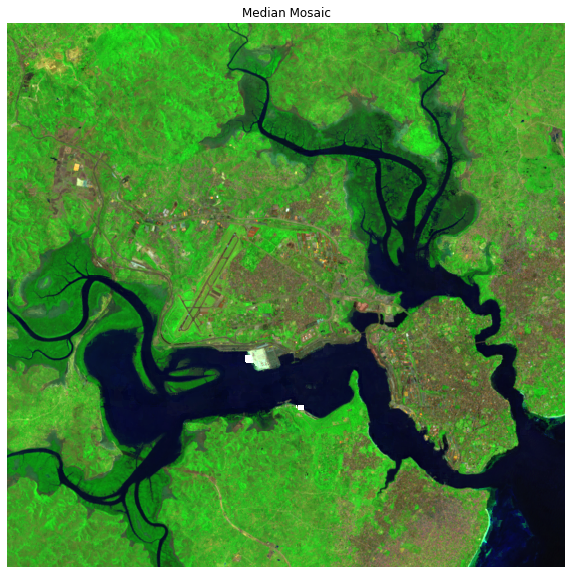

In [12]:
# Show Median Mosaic 

# Select the output image bands for each color (Red, Green, Blue)
# Users can create other combinations of bands, as desired
# True-Color = red, green, blue (this is the common true-color RGB image)
# False-Color = swir2, nir, green (this is commonly used for Landsat data viewing)

median_rgb = median_composite[['swir2', 'nir', 'green']].to_array()

# Define the plot settings and show the plots
# Users may want to alter the figure sizes or plot titles
# The "vmax" value controls the brightness of the images and can be adjusted 

median_rgb.plot.imshow(vmin=0, vmax=5000, figsize=(10,10))
plt.title("Median Mosaic")
plt.axis('off')
plt.show()

## <span id="export">Create GeoTIFF Output Product [&#9652;](#top)</span>

In [13]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

In [14]:
# MODIFY HERE

# Change the name of the output file, or it will be overwritten for each run 
# The output file can be found using the "file" icon on the Colab menu on the left

export_slice_to_geotiff(median_composite, './output/DEMO_median_composite.tif')